# Antialiasfilter: Hvorfor og hvordan?

# Målet for denne forelesningen:

* Å få en intuitiv forståelse av aliasing.
* Å forstå hva et antialiasfilter er, hvorfor vi vil bruke det og hvordan det kan implementeres.


Mye av koden i denne jupyter nootbooken er inspirert av https://dspillustrations.com/pages/posts/misc/aliasing-and-anti-aliasing-filter.html.

# Fra tidligere kjenner vi Nyquists punktprøvingsteorem

La oss se på spekteret til et tenkt signal:
<img src="figurer/20200503_124010~2.jpg" alt="Drawing" style="width: 400px;"/>
Dette spekteret er lik null for frekvenser høyere enn B.

For å kunne punktprøve dette signalet og gjenskape det eksakt må punktprøvingsfrekvensen $f_s$ være større enn $2B$: 

$$f_s > 2B$$


# Hva skjer når punktprøvingsfrekvensen er mindre enn to ganger båndbredden?

Når $f_s < 2B$:
1. Vi får bare gjenskapt den delen av signalet under $B$.
2. Vi kan gjennom maskinlæring og lure algoritmer gjenskapet signalet selv om $f_s < 2B$, så det er egentlig ikke noe problem.
3. Frekvensene over $B$ vil bli tolket som frekvenser under $B$ når signalet gjenskapes.
4. Vet ikke.



# La oss se på et lite musikkstykke:

(Men først må vi importere de nødvendige bibliotekene.)

In [13]:
import requests
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np
from IPython.display import Audio, display, HTML
%matplotlib inline
import librosa
from ipywidgets import interact
plt.rcParams["figure.figsize"] = (20,10)

font = {'size'   : 16}
matplotlib.rc('font', **font)


Her er den originale innspillingen med en punktprøvingsfrekvens på 44100 Hz.

In [5]:
Audio(data="prelude_cmaj_10s.wav")

Så lager vi en funksjon som reduserer punktprøvingsfrekvensen med en faktor.

In [19]:
def alias(original, rate, faktor):
    down_aliased = original[::faktor] # fjerner alle punktprøvinger bortsett fra hver faktor'te punktprøving

    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("Med aliasing:"), Audio(data=down_aliased, rate=rate/faktor))

In [16]:
data, ppfrek = librosa.load("prelude_cmaj_10s.wav",sr=None)

Et slikt musikkstykke vil ha mange forskjellige frekvenskomponenter, noen som vil være større enn $f_s/2$ når vi senker punktprøvingsfrekvensen.

In [21]:
faktor = 2
alias(data,ppfrek,faktor)

# Hva er det som skjer når vi reduserer punktprøvingsfrekvensen? 

Som vi vet så kan alle signal uttrykkes som en rekke av sinussinal med forskjellig frekvens. Så la oss prøve med et sinussignal med gradvis økende frekvens i stedet for musikkstykket vi nettopp hørte.


In [22]:
Fs = 44100 #punktprøvingsfrekvensen til signalet vårt
t = np.arange(0, 10, 1/Fs) #lager tidsstegene
f = 200*t #frekvensene vi ser på
data_sinus_f = np.sin(2*np.pi*f*t)*1/(np.sqrt(1+(2*np.pi*f*1000*(318*1e-9))**2)) #lager signalet
rate_sinus_f = Fs
alias(data_sinus_f, rate_sinus_f, 10)

Hva var det som skjedde?

In [24]:
def aliasMedAntialiasfilter(original, rate, factor):
    down_aliased = original[::factor] # fjerner alle punktprøvinger bortsett fra hver factor'te punktprøving

    b = signal.firwin(155, 1.0/factor-0.01); a=1  # lager lavpassfilter
    lowpass = signal.lfilter(b, a, original)      # bruker lavpassfilteret på signalet
    down_nonaliased = lowpass[::factor]           # fjerner alle punktprøvinger bortsett fra hver factor'te punktprøving

    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("Med aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    display(HTML("Med anti aliasing filter:"), Audio(data=down_nonaliased,rate=rate/factor))

In [7]:
Fs = 1000      # samplingsfrekvensen [Hz]
F_plot = 100000  # oppløsningen til det tidskontinuerlige signalet
T = 0.02       # tiden vi ser på signalet
t = np.arange(0, T, 1/Fs)  # tidene signalet samples
t_plot = np.arange(0, t.max(), 1/F_plot)  # tidene det tidskontinuerlige signalet plottes
t_ms = np.arange(0, T*1000, 1/Fs*1000)  # tidene signalet samples i ms
t_plot_ms = np.arange(0, t.max()*1000, 1/F_plot*1000) # tidene det tidskontinuerlige signalet plottes i ms

def showAlias(f1):
    f2 = min(f1, Fs-f1)  # finner aliasfrekvensen
    xt1 = lambda t: np.cos(2*np.pi*f1*t) # lager sinusfunksjonene
    xt2 = lambda t: np.cos(2*np.pi*f2*t)
    
    # plott av signalet og aliaset
    plt.subplot(121)
    plt.plot(t_plot_ms, xt1(t_plot), 'b-', lw=2, label='innsignal')
    plt.plot(t_plot_ms, xt2(t_plot), 'g-', label='rekonstruert signal')
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t), x[n]$')
    plt.stem(t_ms, xt1(t), label='målepunkt')
    plt.legend(loc="upper left")
    plt.ylim((-1.1, 1.5))
    
    # plott av spekteret til signalene
    t_freq = np.arange(0, 20*T, 1/F_plot) 
    x1 = xt1(t_freq)
    x2 = xt2(t_freq)
    X1 = np.fft.fftshift(np.fft.fft(x1, 8*len(x1))) / len(x1)
    X2 = np.fft.fftshift(np.fft.fft(x2, 8*len(x1))) / len(x2)
    f = np.linspace(-F_plot/2, F_plot/2, len(X1), endpoint=False)
    plt.subplot(122)
    plt.plot(f, abs(X1), lw=2, label='innsignal')
    plt.plot(f, abs(X2), label='rekonstruert signal')
    plt.xlim(0,1000)
    plt.xlabel('$f$ [Hz]'); plt.ylabel('$|X(f)|$')
    plt.legend(loc="upper right")
    plt.text(x=0.5, y=0.5, s='$f_{in}=%.2f$ Hz \n $f_{out}=%.2f$ Hz' % (f1, f2), bbox=dict(facecolor='white'))
    
plt.figure();
interact(showAlias, f1=(0,1000, 1));

<Figure size 1440x720 with 0 Axes>

interactive(children=(IntSlider(value=500, description='f1', max=1000), Output()), _dom_classes=('widget-inter…

In [20]:
def loadAudio(file):
    
    rate, data = wavfile.read(file)
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    
    return rate, data

In [148]:
Fs = 1000      # samplingsfrekvensen [Hz]
F_plot = 100000  # oppløsningen til det tidskontinuerlige signalet
T = 0.02       # tiden vi ser på signalet
t = np.arange(0, T, 1/Fs)  # tidene signalet samples
t_plot = np.arange(0, t.max(), 1/F_plot)  # tidene det tidskontinuerlige signalet plottes
t_ms = np.arange(0, T*1000, 1/Fs*1000)  # tidene signalet samples i ms
t_plot_ms = np.arange(0, t.max()*1000, 1/F_plot*1000) # tidene det tidskontinuerlige signalet plottes i ms

def showAlias(f1,R,C):
    aa = lambda f: 1/(np.sqrt(1+(2*np.pi*f*R*(C*1e-9))**2)) #filterets amplituderespons
    
    f2 = min(f1, Fs-f1)  # finner aliasfrekvensen
    xt1 = lambda t: np.cos(2*np.pi*f1*t) # innsignalet
    xt2 = lambda t: np.cos(2*np.pi*f2*t)*aa(f1) #signalet etter filteret
    
    
    # plott av signalet og aliaset
    plt.subplot(221)
    plt.plot(t_plot_ms, xt1(t_plot), 'b-', lw=2, label='originalt signal')
    plt.plot(t_plot_ms, xt2(t_plot), 'g-', label='rekonstruert signal')
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t), x[n]$')
    plt.stem(t_ms, xt1(t), label='målepunkt')
    plt.legend(loc="upper left")
    plt.ylim((-1.1, 1.5))
    
    # plott av spekteret til signalene
    t_freq = np.arange(0, 20*T, 1/F_plot) 
    x1 = xt1(t_freq)
    x2 = xt2(t_freq)
    X1 = np.fft.fftshift(np.fft.fft(x1, 8*len(x1))) / len(x1)
    X2 = np.fft.fftshift(np.fft.fft(x2, 8*len(x1))) / len(x2)
    f = np.linspace(-F_plot/2, F_plot/2, len(X1), endpoint=False)
    plt.subplot(222)
    plt.plot(f, abs(X1), lw=2, label='innsignal')
    plt.plot(f, abs(X2), label='etter punktprøving')
    plt.xlim(0,1000)
    plt.xlabel('$f$ [Hz]'); plt.ylabel('$|X(f)|$')
    plt.legend(loc="upper right")
    plt.text(x=0.5, y=0.5, s='$f_{in}=%.2f$ Hz \n $f_{out}=%.2f$ Hz' % (f1, f2), bbox=dict(facecolor='white'))
    
    #plott av amplituderesponsen til antialiasfilteret
    plt.subplot(223)
    plt.plot(np.log(f),np.log10(aa(f)))

    
plt.figure()
interact(showAlias, f1=(0,1000),R=(1,1000),C=(1,1000));

<Figure size 1440x720 with 0 Axes>

interactive(children=(IntSlider(value=500, description='f1', max=1000), IntSlider(value=500, description='R', …

In [163]:
Fs = 44100
t = np.arange(0, 10, 1/Fs)
f = 200*t
data_chirp = np.sin(2*np.pi*f*t)
rate_chirp = Fs
presentAliasingAudio(data_chirp, rate_chirp, 10)

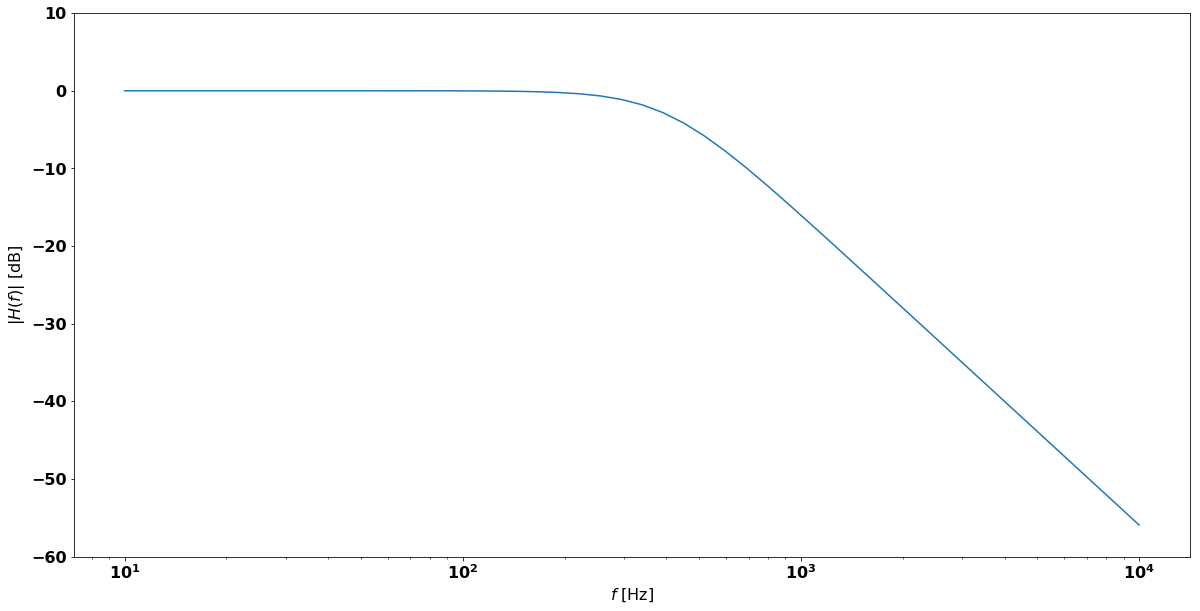

In [178]:
bw_f = np.logspace(1,4) #genererer frekvenser fra 1 Hz til 1e4 Hz
bw_n = 2 #ordenen til filteret
bw_fc = 400 #knekkfrekvensen til filteret
bw_amp = 1/np.sqrt(1+(bw_f/bw_fc)**(2*bw_n))
plt.semilogx(bw_f, 20*np.log10(bw_amp))
plt.xlabel('$f$ [Hz]'); plt.ylabel('$|H(f)|$ [dB]');
plt.ylim(-60,10);


In [181]:
Fs = 44100
t = np.arange(0, 10, 1/Fs)
f = 200*t

bw_n = 6 #ordenen til filteret
bw_fc = 400 #knekkfrekvensen til filteret
bw_amp = 1/np.sqrt(1+(f/bw_fc)**(2*bw_n))

data_chirp = np.sin(2*np.pi*f*t)*1/np.sqrt(1+(f/bw_fc)**(2*bw_n))
rate_chirp = Fs
presentAliasingAudio(data_chirp, rate_chirp, 10)